In [179]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpy as np

import plot

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score

from sklearn.utils import shuffle

In [95]:
CAREER_LENGTH = 1

#EARLY_CAREER_LEN_LIST = [1, 2, 3, 4, 5]
EARLY_CAREER_LEN_LIST = [3]
EARLY_CAREER = 3
#RECOGNITION_CUT_OFF_LIST = [3, 4, 5, 6, 7, 8, 9]
RECOGNITION_CUT_OFF_LIST = [3]
RECOGNITION_CUT = 3

MAX_CAREER_LEN = 15
END_YEAR = 2018

INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 0
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 1

# if true, all authors with gender=none are removed from cohort
REMOVE_NONE_AUTHORS = False

In [4]:
credible_authors = pd.read_csv('derived-data/authors-scientific-extended.csv')

In [5]:
credible_authors.columns
#print(credible_authors.groupby("start_year")['dropped_after_10'].agg('sum'))
#print(credible_authors.groupby("start_year")['author'].count())

Index(['author', 'start_year', 'end_year', 'total_num_pub', 'career_length',
       'max_absence-0-15', 'avg_absence-0-15', 'dropped_after_10', 'gender',
       'early_career_degree_3', 'early_career_degree_5',
       'early_career_degree_7', 'early_career_degree_9',
       'early_career_degree_11', 'early_career_degree_12',
       'early_career_qual_3', 'early_career_qual_5', 'early_career_qual_7',
       'early_career_qual_9', 'early_career_qual_11', 'early_career_qual_12',
       'succ_after_15y', 'early_career_prod_3', 'early_career_prod_5',
       'early_career_prod_7', 'early_career_prod_9', 'early_career_prod_11',
       'early_career_prod_12', 'early_career_coauthor_max_hindex_3',
       'early_career_coauthor_max_hindex_5',
       'early_career_coauthor_max_hindex_7',
       'early_career_coauthor_max_hindex_9',
       'early_career_coauthor_max_hindex_11',
       'early_career_coauthor_max_hindex_12',
       'early_career_coauthor_max_cit_3', 'early_career_coauthor_max_cit_5'

In [6]:
credible_authors = credible_authors[credible_authors.career_length >= CAREER_LENGTH]

In [ ]:
# credible_authors['citation_increase_15_3'] = credible_authors['succ_after_15y'] - credible_authors[
#     'early_career_recognition_EC3_RC3']
# credible_authors['h_index_increase_15_3'] = credible_authors['h-index_15'] - credible_authors['h-index_3']

## Data first look

In [ ]:
credible_authors.columns

In [ ]:
credible_authors.head()

## Correlations

In [ ]:
cor_qual = credible_authors.corr()

In [ ]:
cor_qual
#cor_qual['succ_after_15y'].sort_values()

In [ ]:
#cor_rec = credible_authors[['early_career_recognition_EC1_RC3', 'early_career_recognition_EC1_RC5',
#       'early_career_recognition_EC1_RC7', 'early_career_recognition_EC1_RC9',
#       'early_career_recognition_EC2_RC3', 'early_career_recognition_EC2_RC5',
#       'early_career_recognition_EC2_RC7', 'early_career_recognition_EC2_RC9',
#       'early_career_recognition_EC3_RC3', 'early_career_recognition_EC3_RC5',
#       'early_career_recognition_EC3_RC7', 'early_career_recognition_EC3_RC9',
#       'early_career_recognition_EC4_RC5', 'early_career_recognition_EC4_RC7',
#       'early_career_recognition_EC4_RC9', 'early_career_recognition_EC5_RC5',
#       'early_career_recognition_EC5_RC7', 'early_career_recognition_EC5_RC9',
#       'succ_after_15y']].corr()

In [ ]:
#cor_rec['succ_after_15y'].sort_values()

In [ ]:
cor = credible_authors.corr()

In [ ]:
cor['citation_increase_15_3'].sort_values()

In [ ]:
sns.heatmap(cor, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Linear reg

### Test different predictors

In [ ]:
# test different early career lenghts

In [ ]:
year = 1995

credible_authors_1991 = credible_authors[credible_authors.start_year == year]

In [ ]:
X = credible_authors_1991.copy()


In [ ]:
categorical_cols = ['gender']

for col in categorical_cols:
    X = X.join(pd.get_dummies(X[categorical_cols]))

X.drop(categorical_cols, axis=1, inplace=True)

In [ ]:
def run_linear(func, name):
    df = pd.DataFrame(columns=['params', f'r_squared_{name}'])
    for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
        for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
            if RECOGNITION_CUT < EARLY_CAREER: continue
            H = X[[
                #'max_absence-0-3', 'avg_absence-0-3',
                   'gender_f', 'gender_m', 'gender_none',
                   f'early_career_degree_{EARLY_CAREER}', 
                   f'early_career_prod_{EARLY_CAREER}',
                   f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
            reg = func.fit(H, y)
            df = df.append({'params': f'EC:{EARLY_CAREER},REC:{RECOGNITION_CUT}',
                            f'r_squared_{name}': reg.score(H, y)}, ignore_index=True)
    return df

In [ ]:
def run_cv(func, name, cv, y_col='succ_after_15y'):
    df = pd.DataFrame(columns=['params', f'r_squared_{name}'])
    for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
        for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
            if RECOGNITION_CUT < EARLY_CAREER: continue
            H = X[[
                #'max_absence-0-3', 'avg_absence-0-3',
                   'gender_f', 'gender_m', 'gender_none',
                   f'early_career_degree_{EARLY_CAREER}', 
                   f'early_career_prod_{EARLY_CAREER}',
                   f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
            y = X[y_col]
            score = np.mean(cross_val_score(func, H, y, cv=cv, scoring='r2'))
            df = df.append({'params': f'EC:{EARLY_CAREER},REC:{RECOGNITION_CUT}',
                            f'r_squared_{name}': score}, ignore_index=True)
    return df

In [ ]:
df1 = run_cv(LinearRegression(), 'linear', cv=3)

In [ ]:
# df1_null = run_cv(LinearRegression(), 'linear_null', cv=3, y_col='succ_shuffled')

In [ ]:
df2 = run_cv(ElasticNet(), 'elastic', cv=3)

In [ ]:
df3 = run_cv(ElasticNetCV(cv=3), 'elastic_CV', cv=3)

In [ ]:
df4 = run_cv(Lasso(alpha=0.1), 'lasso', cv=3)

In [ ]:
# Decision tree overfits pretty bad. Maybe GridParam Search?
df5 = run_cv(DecisionTreeRegressor(), 'tree', cv=3)

In [ ]:
df6 = run_cv(RandomForestRegressor(), 'forest', cv=3)

In [ ]:
# df6_null = run_cv(RandomForestRegressor(), 'forest_null', cv=3, y_col='succ_shuffled')

In [ ]:
dfs = [df1, df2, df3, df4, df5, df6] #df1_null, df6_null
for df_ in dfs: df_.set_index('params', inplace=True)

In [ ]:
dfs[0].join(dfs[1:])

### Elastic net

In [227]:
years = sorted(credible_authors.start_year.unique())
cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LEN)]
# EARLY_CAREER = EARLY_CAREER_LEN_LIST[0]
# RECOGNITION_CUT = RECOGNITION_CUT_OFF_LIST[0]

In [228]:
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [249]:
# 4 groups of features: productivity, social capital, quality/rec and gender
def make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS, 
                    EARLY_CAREER, RECOGNITION_CUT):
    cols_std = []
    cols_all = ['cohort_size']

    if(INCLUDE_PROD):
        cols_std.append(f'early_career_prod_{EARLY_CAREER}')
        cols_all.append(f'early_career_prod_{EARLY_CAREER}')

    if(INCLUDE_SOCIAL):
        cols_std.append(f'early_career_degree_{EARLY_CAREER}')
        cols_all.append(f'early_career_degree_{EARLY_CAREER}')
        cols_std.append(f'early_career_coauthor_max_hindex_{EARLY_CAREER}')
        cols_all.append(f'early_career_coauthor_max_hindex_{EARLY_CAREER}')
    #     cols_std.append(f'early_career_coauthor_max_cit_{EARLY_CAREER}')
    #     cols_all.append(f'early_career_coauthor_max_cit_{EARLY_CAREER}')

    if(INCLUDE_REC):
        cols_std.append(f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}')
        cols_all.append(f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}')

    if(INCLUDE_QUALITY):
        cols_std.append(  f'early_career_qual_{EARLY_CAREER}')
        cols_all.append(  f'early_career_qual_{EARLY_CAREER}')

    if(INCLUDE_GENDER):
        cols_all.append('gender_m')
        cols_all.append('gender_f')
        if(not REMOVE_NONE_AUTHORS):
            cols_all.append('gender_none')


    cols_all.append('intercept')
    cols_all.append('r2')
    categorical_cols = ['gender']
    return cols_all, cols_std, categorical_cols
num_splits = 5

In [251]:
def run_elastic_predictions(cols_all, cols_std, categorical_cols, EARLY_CAREER):
    feature_table = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
    feature_table2 = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
    feature_table3 = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
 
    for year in cohort_start_years:
        credible_authors_year = credible_authors[credible_authors.start_year == year]

        X = credible_authors_year.copy()

        #remove non-gender rows
        if(REMOVE_NONE_AUTHORS):
            X = X[X["gender"]!="none"]

        # Make dummy values for categorical columns
        gender_cols = pd.get_dummies(X[categorical_cols])

        #if(not REMOVE_NONE_AUTHORS):
            # drop gender none?
            # this is removing rows gender_none col
            #gender_cols.drop('gender_none', axis=1, inplace=True)

        #standardize cols_std
        standardized_cols = RobustScaler().fit_transform(X[cols_std])


        # claudia: here we could do a 20:80 split and save 20% for later test

        #combine
        H = pd.DataFrame(standardized_cols, index=X.index, columns=cols_std)
        if(INCLUDE_GENDER):
            H = H.join(gender_cols)

        y = X[f'h_index_increase_15_{EARLY_CAREER}']
        y2 = X[f'citation_increase_15_{EARLY_CAREER}']
        y3 = X['dropped_after_10'].astype(int)

        cv_dict = cross_validate(ElasticNetCV(cv=3), H, y, scoring='r2', cv=5, return_estimator=True, return_train_score=False)
        cv2_dict = cross_validate(ElasticNetCV(cv=3), H, y2, scoring='r2', cv=5, return_estimator=True, return_train_score=False)
        cv3_dict = cross_validate(LogisticRegressionCV(cv=3), H, y3, scoring="f1", cv=5, return_estimator=True, return_train_score=False)

        score = np.mean(cv_dict['test_score'])
        score2 = np.mean(cv2_dict['test_score'])
        score3 = np.mean(cv3_dict['test_score'])

        net_coef = pd.DataFrame([es.coef_ for es in cv_dict['estimator']], columns=H.columns)
        net2_coef = pd.DataFrame([es.coef_ for es in cv2_dict['estimator']], columns=H.columns)
        net3_coef = pd.DataFrame([es.coef_[0] for es in cv3_dict['estimator']], columns=H.columns)

        net_intercept = np.mean([es.intercept_ for es in cv_dict['estimator']])
        net2_intercept = np.mean([es.intercept_ for es in cv2_dict['estimator']])
        net3_intercept = np.mean([es.intercept_ for es in cv3_dict['estimator']])

        net_coef_mean, net2_coef_mean, net3_coef_mean = net_coef.mean(), net2_coef.mean(), net3_coef.mean()
        net_coef_std, net2_coef_std, net3_coef_std = net_coef.std(), net2_coef.std(), net3_coef.std()

        rounding = 2

        net_coef_mean_std = list(zip(np.round(net_coef_mean.values,rounding), np.round(net_coef_std.values,rounding)))
        net2_coef_mean_std = list(zip(np.round(net2_coef_mean.values,rounding), np.round(net2_coef_std.values,rounding)))
        net3_coef_mean_std = list(zip(np.round(net3_coef_mean.values,rounding), np.round(net3_coef_std.values,rounding)))
        
        net_coef_mean_std = [f"{x[0]}({x[1]})" for x in net_coef_mean_std]
        net2_coef_mean_std = [f"{x[0]}({x[1]})" for x in net2_coef_mean_std]
        net3_coef_mean_std = [f"{x[0]}({x[1]})" for x in net3_coef_mean_std]

        cohort_size = len(y2)
    #     num_nonzero_coefs = sum(net2.coef_ != 0)
    #     adj_score2 = 1 - (1-score2)*(cohort_size-1)/(cohort_size-num_nonzero_coefs-1)
        net_coef_mean_std.extend([np.round(net_intercept, rounding), np.round(score, rounding), cohort_size])
        net2_coef_mean_std.extend([np.round(net2_intercept, rounding), np.round(score2, rounding), cohort_size])
        net3_coef_mean_std.extend([np.round(net3_intercept, rounding), np.round(score3, rounding), cohort_size])


        year_data = pd.DataFrame(list(zip(np.append(H.columns, ['intercept', 'r2', 'cohort_size']), 
                                          net_coef_mean_std)), 
                                 columns=['year', year]).set_index('year')
        year_data2 = pd.DataFrame(list(zip(np.append(H.columns, ['intercept', 'r2', 'cohort_size']), 
                                          net2_coef_mean_std)), 
                                 columns=['year', year]).set_index('year')
        year_data3 = pd.DataFrame(list(zip(np.append(H.columns, ['intercept', 'r2', 'cohort_size']), 
                                          net3_coef_mean_std)),
                                 columns=['year', year]).set_index('year')

        feature_table = feature_table.join(year_data)
        feature_table2 = feature_table2.join(year_data2)
        feature_table3 = feature_table3.join(year_data3)
    return feature_table, feature_table2, feature_table3

#### Feature tables

In [252]:
def make_result_table(feature_table):
    results = feature_table.transpose()
    #shorten column names
    new_cols = dict(zip(results.columns, [col.replace('early_career', 'ec') for col in results.columns]))

    results.rename(new_cols, axis='columns', inplace=True)
    results.rename({'feature':'cohort','ec_coauthor_max_cit_3': 'ec_coauth_max_cit_3', 'ec_recognition_EC3_RC5':'ec_recog_EC3_RC5'}, axis='columns', inplace=True)
    return results

In [253]:
def results_to_latex(results, name):
    ltx_file = open(f"results_{name}.tex", "w")
    ltx_file.write('\n'.join(results.to_latex().split('\n')[4:-3]))
    ltx_file.close()

In [254]:
EARLY_CAREER = 3
RECOGNITION_CUT = 3

In [255]:
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 1
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 1
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, 
                                                       INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)

In [ ]:
feature_table, feature_table2, feature_table3 = run_elastic_predictions(cols_all, cols_std, categorical_cols, EARLY_CAREER)

In [ ]:
results = make_result_table(feature_table)
results2 = make_result_table(feature_table2)
results3 = make_result_table(feature_table3)

In [ ]:
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 1
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 0
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, 
                                                       INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)
feature_table, feature_table2, feature_table3 = run_elastic_predictions(cols_all, cols_std, categorical_cols, EARLY_CAREER)
results_no_qual = make_result_table(feature_table)
results2_no_qual = make_result_table(feature_table2)
results3_no_qual = make_result_table(feature_table3)

In [ ]:
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 0
INCLUDE_GENDER = 0
INCLUDE_QUALITY = 1
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC,
                                                       INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)
feature_table, feature_table2, feature_table3 = run_elastic_predictions(cols_all, cols_std, categorical_cols, EARLY_CAREER)
results_no_gen_no_rec = make_result_table(feature_table)
results2_no_gen_no_rec = make_result_table(feature_table2)
results3_no_gen_no_rec = make_result_table(feature_table3)

In [ ]:
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 0
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 1
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC,
                                                       INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)
feature_table, feature_table2, feature_table3 = run_elastic_predictions(cols_all, cols_std, categorical_cols, EARLY_CAREER)
results_no_rec = make_result_table(feature_table)
results2_no_rec = make_result_table(feature_table2)
results3_no_rec = make_result_table(feature_table3)

In [ ]:
results['r2_no_rec'] = results_no_rec['r2']
results2['r2_no_rec'] = results2_no_rec['r2']
results3['f1_no_rec'] = results3_no_rec['r2']

In [ ]:
results['r2_no_qual_rc3'] = results_no_qual['r2']
results2['r2_no_qual_rc3'] = results2_no_qual['r2']
results3['f1_no_qual_rc3'] = results3_no_qual['r2']

In [ ]:
results['r2_no_gender'] = results_no_gen['r2']
results2['r2_no_gender'] = results2_no_gen['r2']
results3['r2_no_gender'] = results3_no_gen['r2']

In [ ]:
dropped_percent = credible_authors.groupby('start_year')['dropped_after_10'].sum() / credible_authors.groupby('start_year')['dropped_after_10'].count()

In [ ]:
results3['drop_percentage'] = dropped_percent.round(2)

In [ ]:
results.head()

In [ ]:
results2.head()

In [ ]:
results3.head()

In [161]:
results_to_latex(results, 'hindex')
results_to_latex(results2, 'cit')
results_to_latex(results3, 'dropout')

In [ ]:
results
# h index increase
#results.to_latex()

In [ ]:
results2
# citation increase

In [ ]:
results3
# coefficients are not exponentiated
# positive means bigger change to drop

#### Test predictive power over different number of observed years

In [189]:
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 1
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 0

EARLY_CAREER_LEN_LIST = [3,5,7,9,11,12]
RECOGNITION_CUT_OFF_LIST = [3,5,7,9,11,12]

In [168]:
for year in EARLY_CAREER_LEN_LIST:
    credible_authors[f'citation_increase_15_{year}'] = credible_authors['succ_after_15y'] - credible_authors[
        f'early_career_recognition_EC{year}_RC{year}']
    credible_authors[f'h_index_increase_15_{year}'] = credible_authors['h-index_15'] - credible_authors[f'h-index_{year}']

In [169]:
credible_authors.columns

Index(['author', 'start_year', 'end_year', 'total_num_pub', 'career_length',
       'max_absence-0-15', 'avg_absence-0-15', 'dropped_after_10', 'gender',
       'early_career_degree_3', 'early_career_degree_5',
       'early_career_degree_7', 'early_career_degree_9',
       'early_career_degree_11', 'early_career_degree_12',
       'early_career_qual_3', 'early_career_qual_5', 'early_career_qual_7',
       'early_career_qual_9', 'early_career_qual_11', 'early_career_qual_12',
       'succ_after_15y', 'early_career_prod_3', 'early_career_prod_5',
       'early_career_prod_7', 'early_career_prod_9', 'early_career_prod_11',
       'early_career_prod_12', 'early_career_coauthor_max_hindex_3',
       'early_career_coauthor_max_hindex_5',
       'early_career_coauthor_max_hindex_7',
       'early_career_coauthor_max_hindex_9',
       'early_career_coauthor_max_hindex_11',
       'early_career_coauthor_max_hindex_12',
       'early_career_coauthor_max_cit_3', 'early_career_coauthor_max_cit_5'

In [171]:
EARLY_CAREER_LEN_LIST = [3, 9, 12]
RECOGNITION_CUT_OFF_LIST = [3, 9, 12]

In [172]:
r2_increase = pd.DataFrame(index=years)
for EARLY_CAREER, RECOGNITION_CUT in zip(EARLY_CAREER_LEN_LIST, RECOGNITION_CUT_OFF_LIST):
    cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, 
                                         REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)
    feature_table, feature_table2, feature_table3 = run_elastic_predictions(cols_all, cols_std, categorical_cols, EARLY_CAREER)
    results= make_result_table(feature_table)
    results2 = make_result_table(feature_table2)
    results3 = make_result_table(feature_table3)
    r2_increase[f'h_ind_{EARLY_CAREER}'] = results['r2']
    r2_increase[f'cit_{EARLY_CAREER}'] = results2['r2']
    r2_increase[f'drop_{EARLY_CAREER}'] = results3['r2']
    print(f"Year: {EARLY_CAREER}")
    print(cols_all)
    print(r2_increase[f'h_ind_{EARLY_CAREER}'][2002])

Year: 3
['cohort_size', 'early_career_prod_3', 'early_career_degree_3', 'early_career_coauthor_max_hindex_3', 'early_career_recognition_EC3_RC3', 'gender_m', 'gender_f', 'gender_none', 'intercept', 'r2']
0.33
Year: 9
['cohort_size', 'early_career_prod_9', 'early_career_degree_9', 'early_career_coauthor_max_hindex_9', 'early_career_recognition_EC9_RC9', 'gender_m', 'gender_f', 'gender_none', 'intercept', 'r2']
0.53


KeyboardInterrupt: 

In [188]:
EARLY_CAREER_LEN_LIST

[3, 9, 12]

In [164]:
r2_increase_backup = r2_increase.copy()

In [206]:
r2_hind_increase = r2_increase_backup[[f"h_ind_{x}" for x in EARLY_CAREER_LEN_LIST]]
r2_cit_increase = r2_increase_backup[[f"cit_{x}" for x in EARLY_CAREER_LEN_LIST]]
r2_drop_increase = r2_increase_backup[[f"drop_{x}" for x in EARLY_CAREER_LEN_LIST]]

In [216]:
r2_hind_increase.columns = ['3','5','7','9','11','12']

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


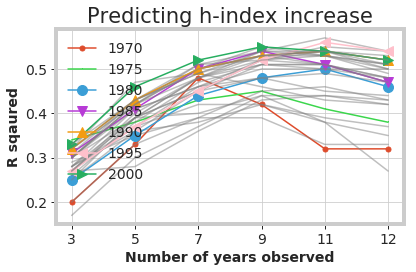

In [218]:
plt = plot.init_plotting()
fig2 = plt.figure()
fig2.patch.set_facecolor('white')
ax2 = fig2.add_subplot(1,1,1) #, axisbg="white"
colors = ('#DE4C2C', '#3BD64C', '#3B9ED6', '#B73BD6', '#F39C12', '#FFC0CB', '#27AE60', '#48C9B0', '#071019') #'#AAB7B8',
markers = []
for m in Line2D.markers:
    try:
        if m != ' ' and m != '':
            markers.append(m)
    except TypeError:
        print("Typeerror occured")
        pass
p=0
for row in r2_hind_increase.index:

    cohort = r2_hind_increase.loc[year]
    
    if row % 5 == 0:
        ax2.plot(r2_hind_increase.loc[row], label=row, color=colors[p],
                     marker=markers[p], markersize=10)
        p = p+1 
    else:
        ax2.plot(r2_hind_increase.loc[row].values, label=None ,color='grey', alpha=0.5)

plt.title("Predicting h-index increase")
ax2.set_ylabel("R sqaured", fontweight='bold')
ax2.set_xlabel('Number of years observed', fontweight='bold')

ax2.legend()
plt.show()

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


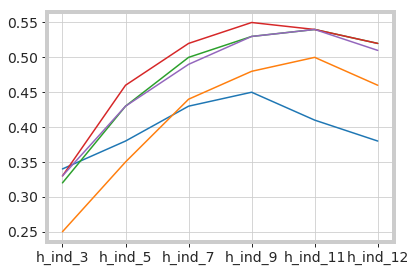

In [185]:
r2_hind_increase

for row in r2_hind_increase.index:
    plt.plot(r2_hind_increase.loc[row])

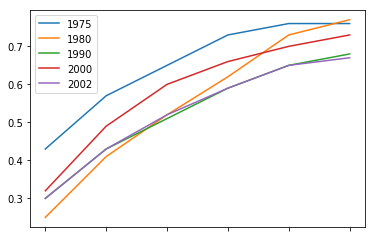

In [79]:
r2_cit_increase.T.plot()

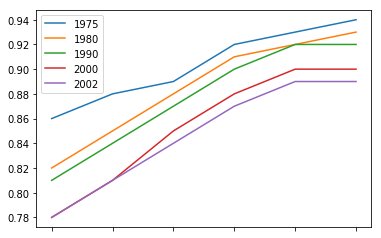

In [77]:
r2_drop_increase.T.plot()

#### predictor diffs

In [ ]:
h_index = feature_table.transpose().copy()
citations = feature_table2.transpose().copy()

In [ ]:
plt.plot(h_index['r2'], label='Increase H index')
plt.plot(citations['r2'], label='Increase Citations')
print("Average difference in r squared", sum(citations['r2']-h_index['r2'])/len(h_index['r2']))
# quality was used as a feature!
plt.legend()
plt.show()

#### gender diffs

In [ ]:
# gender coefs
plt.plot(results3['gender_m'], label="Male")
plt.plot(results3['gender_f'], label="Female")
plt.legend()
plt.show()

In [ ]:
plt.plot(results3['gender_m'] - results3['gender_f'], label="Male-Female diff")
plt.plot(results.index ,np.zeros(len(results)))
plt.legend()
plt.show()

#### cohort size diffs

In [ ]:
fig, ax1 = plt.subplots()
# ax1.plot(results['r2'], label='r2')
ax1.plot(results['adj_r2'], label='adjusted r2', color='C2')
ax1.set_ylim([0,1])
ax1.set_xlabel('Years')
ax1.set_ylabel('R squared', color='C2')
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(results['cohort_size'], label='Cohort size', color='C3')
ax2.set_ylabel('Cohort size', color='C3')
ax2.legend(loc=4)
plt.show()

#### cheating diffs

In [ ]:
no_cheating = feature_table2.transpose().copy()

In [ ]:
cheat_RC5 = feature_table2.transpose().copy()

In [ ]:
cheat_quality = feature_table2.transpose().copy()

In [ ]:
# How does removing the quality affect the r squared?
plt.plot(with_quality['adj_r2'], label='With quality')
plt.plot(cheat_RC5['adj_r2'], label='With recognition year 5')
plt.plot(no_cheating['adj_r2'], label='No cheating')
print("Average difference in r squared", sum(with_quality['adj_r2']-no_cheating['adj_r2'])/len(cheat_quality))
print(np.mean)
plt.legend()
plt.show()

avg = sum(cheat_quality['adj_r2']-no_cheating['adj_r2'])/len(no_cheating)
plt.plot(cheat_quality['adj_r2']-no_cheating['adj_r2'], label='Difference')
plt.plot(no_cheating.index, [avg]*len(no_cheating), label='Average diff')
plt.title("Difference between quality(15y) and recognition(3y)")
plt.legend()
plt.show()

#### scaler diffs

In [ ]:
std_scaler = feature_table2.transpose().copy()

In [ ]:
rob_scaler = feature_table2.transpose().copy()

In [ ]:
# How does changing the scaler affect the r squared?
plt.plot(std_scaler['adj_r2'], label='Std')
plt.plot(rob_scaler['adj_r2'], label='Rob')
print("Average difference in r squared", sum(std_scaler['adj_r2']-rob_scaler['adj_r2'])/len(rob_scaler))
plt.legend()
plt.show()
# almost no difference

avg = sum(std_scaler['adj_r2']-rob_scaler['adj_r2'])/len(std_scaler)
plt.plot(std_scaler['adj_r2']-rob_scaler['adj_r2'], label='Difference')
plt.plot(std_scaler.index, [avg]*len(std_scaler), label='Average diff')
plt.legend()
plt.show()

In [ ]:
# feature_table3.transpose()

### Best feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE, RFECV
from collections import defaultdict

In [ ]:
def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_regression, k=k)
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_regression, k=k)
        col_name = "Mutual Information"
    
    feat_selector = feat_selector.fit(data_frame, target)
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.columns
    
    return feat_scores 

def get_features_rfe(data_frame, target, model,k=5):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame
    y = target
    selector = RFE(model, k, step=1)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return df

def get_features_rfecv(data_frame, target, model, cv=3):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame
    y = target
    selector = RFECV(model, step=1, cv=cv)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return df

In [ ]:
years = credible_authors.start_year.unique()
years = sorted(years)

In [ ]:
df = credible_authors.copy()

In [ ]:
categorical_cols = ['gender']

for col in categorical_cols:
    df = df.join(pd.get_dummies(df[categorical_cols]))

df.drop(categorical_cols, axis=1, inplace=True)

#### Show k best - F regression or mutual information

In [ ]:
linear = True
# true - fregression
# false - mutual info

In [ ]:
params = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[['max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params.append(show_kbest(X_year, y_year, linear, 5))

In [ ]:
params[0]

In [ ]:
selected_f = defaultdict(int)
for param in params:
    selected = param[param.Support == True]['Attribute'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

#### RFE

In [ ]:
params_rfe = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[[
        #'max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params_rfe.append(get_features_rfe(X_year, y_year, LinearRegression(),k=5))

In [ ]:
selected_f = defaultdict(int)
for param in params_rfe:
    selected = param[param.support == True]['feature'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

#### RFE CV

In [ ]:
params_rfecv = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[['max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params_rfecv.append(get_features_rfecv(X_year, y_year, LinearRegression(),cv=3))

In [ ]:
selected_f = defaultdict(int)
for param in params_rfecv:
    selected = param[param.support == True]['feature'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

### Null experiment

In [ ]:
citations_per_year = pd.read_csv('derived-data/paper-citation-count.csv', header=None, names=['pub_id', 'cit_count'])

In [ ]:
publications = pd.read_csv('derived-data/author-publications.csv')

In [ ]:
# publications.sort_values(by='author').head()

In [ ]:
# remove authors by career_len, and add start year
publications = publications.merge(credible_authors[['author', 'start_year']], on='author')

In [ ]:
publications = publications[publications.year <= publications.year + MAX_CAREER_LEN]

In [ ]:
# citations_per_year.head()

In [ ]:
publications['pub_id'] = shuffle(publications['pub_id']).reset_index(drop=True)

In [ ]:
# publications.sort_values(by='author').head()

In [ ]:
publications = publications.merge(citations_per_year, on='pub_id', how='left')
publications = publications.fillna(0)

In [ ]:
publications.sort_values(by='author').head(20)

In [ ]:
credible_authors[credible_authors.author == "a min tjoa"]['succ_after_15y']

In [ ]:
credible_authors.set_index('author', inplace=True)

In [ ]:
credible_authors['succ_shuffled'] = publications.groupby('author')['cit_count'].sum()

In [ ]:
credible_authors[['succ_shuffled', 'succ_after_15y']].head()

In [ ]:
credible_authors.columns